# Classifing Injury Code based on Occupational Injury Report

Every day, work-related injury records are generated. In order to alleviate the human effort expended with coding such records, the Centers for Disease Control and Prevention (CDC) National Institute for Occupational Safety and Health (NIOSH), in close partnership with the Laboratory for Innovation Science at Harvard (LISH), is interested in improving their NLP/ML model to automatically read injury records and classify them according to the Occupational Injury and Illness Classification System (OIICS).

https://www.topcoder.com/challenges/30103825

OIICS Coding Scheme Definitions: https://wwwn.cdc.gov/wisards/oiics/

## Load the Data

The input training file is a cvs file (with a header) with 4 columns (`text`, `sex`, `age`, and `event`) and 153956 observations.

1. `text`; This column describes the raw injury description text data.

2. `sex`; This is a categorical variable, describing the sex of the related person.

3. `age`; This is a positive integer variable, describing the age of the related person.

4. `event`; This is the target variable, specifying the OIICS label to be classified. There are 48 unique labels in total.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# Load data
data = pd.read_csv('train.csv')

In [3]:
# Examine head of df

data.head()

,text,sex,age,event
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71


In [4]:
# Examine df info

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153956 entries, 0 to 153955
Data columns (total 4 columns):
text     153956 non-null object
sex      153956 non-null int64
age      153956 non-null int64
event    153956 non-null int64
dtypes: int64(3), object(1)
memory usage: 4.7+ MB


In [5]:
# Look at numerical data

data.describe()

,sex,age,event
count,153956.000000,153956.00000,153956.000000
mean,1.354361,38.28868,54.850808
std,0.478321,13.26070,18.526890
min,1.000000,0.00000,10.000000
25%,1.000000,27.00000,43.000000
50%,1.000000,37.00000,62.000000
75%,2.000000,48.00000,70.000000
max,2.000000,96.00000,99.000000


While there do not appear to be any null values, there are min values in the `age` column equal to 0. These are most likely placeholder values for unknown data and will need to be evaluated further. If the age of the injured person can not be determined from the `text`, these values will be imputed with the median value of the `age` column, 37 years old.

In [8]:
# Analyze placeholder values for age

zero_age = data.loc[data.age == 0]
zero_age

,text,sex,age,event
7323,UNK AGE FEMALE ACCIDENTALLY CUT SELF W DIRTY S...,2,0,55
17671,UNK AGE MALE IS A PARKING ATTENDANT AT WORK AN...,1,0,73
24760,UNK AGE MALE C O DOING HEAVY LIFTING AT WORK A...,1,0,71
26503,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55
34429,UNID D MALE WAS THE DRIVER OF A TRACTOR TRAILE...,1,0,26
34890,UNID D MALE WAS COOKING A RETAURANT WHEN PRES...,1,0,32
41930,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55
44621,UNK AGE MALE SUSTAINED AN ELECTRICAL SHOCK AND...,1,0,43
45835,UKN YOM WITH MULTIPLE TRAUMATIC INJURIES AFTER...,1,0,65
58278,UNKNOWN AGE MALE WITH EXPOSURE TO CARBON DIOXI...,1,0,55


Only instance 133289 has the age of the injured person in the text of the report. Thus, it will be set to 13 and the rest of the observations will be set to equal the median value for the `age` column, 37 years old.

In [9]:
# Correct age value for instance 133289

data.loc[133289, 'age'] = 13

# Check

data.iloc[133289]

text     A 13YOF SUSTAINED NEEDLESTICK WHILE OPENING UP...
sex                                                      2
age                                                     13
event                                                   61
Name: 133289, dtype: object

In [10]:
# Impute the median age for the 0 values in the age column

data.age.replace(0, np.median(data.age), inplace=True)

# Check

data.describe()

,sex,age,event
count,153956.000000,153956.000000,153956.000000
mean,1.354361,38.294532,54.850808
std,0.478321,13.251886,18.526890
min,1.000000,5.000000,10.000000
25%,1.000000,27.000000,43.000000
50%,1.000000,37.000000,62.000000
75%,2.000000,48.000000,70.000000
max,2.000000,96.000000,99.000000


This data comes from the CDC and is assumed to be represent injuries from people employed in the US. However, the minimum age in the dataset is less than the legal age of employment (14 years old) set by the US Department of Labor. Let's select a few observations to investigate further if these observations represent injured child laborers or if they are just children injured on work sites.

In [25]:
kids = data.loc[data.age < 14]
print(kids.shape)
sample = kids.sample(n=10)
sample.reset_index(inplace=True)

for i in range(0,len(sample)):
    print(sample.iloc[i].text)
    print('\n')

(94, 4)
13 YOM RIDING A TRACTOR JUMPED OFF HURT LEG DX LOWER LEG FRACTURE


11 YOF MIXING LIVESTOCK FEED IN CONCRETE MIXER FINGERS CAUGHT BRIEFLY IN MIXER  DX  CONTUSION OF FINGER W O DAMAGE TO NAIL


A 13YOF SUSTAINED NEEDLESTICK WHILE OPENING UP CAPPED INSULIN PEN PUNCT TO FINGER


R WRST SPR 13YOWM DELIVERING NEWSPAPERS ON BIKE WAS HIT BY CAR THAT CA ME FROM STOP HIT PT S BACK TIRE PT FELL TO R SIDE NO LOC OR HELMET WORN


13 YOF A VOLUNTEER AT HORSEBACK RIDING CAMP WHEN A HORSE STEPPED ONHER FOOT DX CONTUSION FOOT


6YOM CONT SPRAINED RT FOOT SLIPPED IN FRONT OF MOTHER S CA WHILE DELIV ERING NEWS PAPERS RT FOOT WAS RAN OVER WITH TIRE


13 YOF WAS AT POLICE ACADEMY PRACTICING DRILL PUSHING MATTRESS OVER A FENCE  IT FELL BACK ON HER HEAD NECK  HEAD PAIN  DX NECK STRAIN


8 YOM DX EYE ITCHING AND SWELLING  DUE TO SOMETHING FELL IN EYE AT  WORK


11YOM IN HAY BARN IN LOFT FELL AND HIT HIS HEAD ON CONCRETE FLOOR DX CONCUSSION


13YOM WITH LEFT SHOULDER PAIN THAT WORSENED AFTER HE LIFTED

Hmm...okay they seem like actual work-related injuries...

## Exploratory Data Analysis

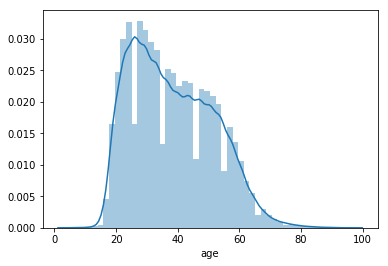

In [27]:
sns.distplot(data.age)
plt.show()

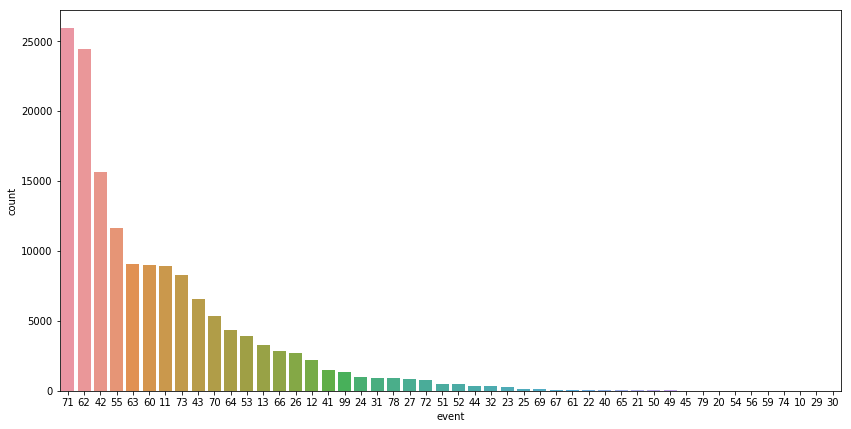

In [37]:
fig = plt.figure(figsize=(14,7))
sns.countplot(data.event, order=data.event.value_counts().index)
plt.show()

In [50]:
data['event_group'] = [0] * len(data)

data.loc[(data.event<20), 'event_group'] = 'Violence by person or animal'
data.loc[(data.event>=20) & (data.event<30), 'event_group'] = 'Transportation incidents'
data.loc[(data.event>=30) & (data.event<40), 'event_group'] = 'Fires and Explosions'
data.loc[(data.event>=40) & (data.event<50), 'event_group'] = 'Falls, Slips, Trips'
data.loc[(data.event>=50) & (data.event<60), 'event_group'] = 'Exposure to harmful substances or environments'
data.loc[(data.event>=60) & (data.event<70), 'event_group'] = 'Contact with objects and equipment'
data.loc[(data.event>=70) & (data.event<80), 'event_group'] = 'Overexertion and Bodily Reaction'
data.loc[(data.event>=99), 'event_group'] = 'Unclassifiable'

data.head()


,text,sex,age,event,event_group
0,57YOM WITH CONTUSION TO FACE AFTER STRIKING IT...,1,57,62,Contact with objects and equipment
1,A 45YOM FELL ON ARM WHILE WORKING HAD SLIPPED ...,1,45,42,"Falls, Slips, Trips"
2,58YOM WITH CERVICAL STRAIN BACK PAIN S P REST...,1,58,26,Transportation incidents
3,33 YOM LAC TO HAND FROM A RAZOR KNIFE,1,33,60,Contact with objects and equipment
4,53YOM AT WORK IN A WAREHOUSE DOING UNSPECIFIED...,1,53,71,Overexertion and Bodily Reaction


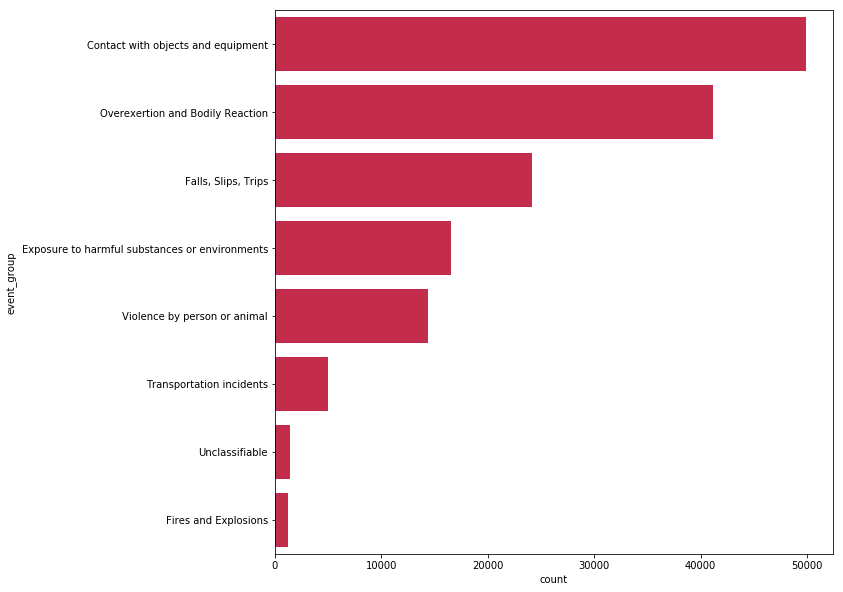

In [75]:
fig = plt.figure(figsize=(10,10))
sns.countplot(y='event_group',
              data=data,
              #orient="h",
              order=data.event_group.value_counts().index, 
              color='crimson')

plt.show()

In [76]:
import spacy

nlp = spacy.load("en_core_web_md")

In [77]:
import re

In [198]:
def get_body_part(txt):
    pattern_head = "(HEAD|NECK|FACE|EYE|NOSE|MOUTH|TEETH|TOOTH|TONGUE|LIP|CHIN|SKULL|EAR|CHEEK)"
#     p_head = re.compile(pattern_head)
#     result_head = p_head.findall(txt)
    
    pattern_arm = "(HAND|FINGER|THUMB|WRIST|ARM|SHOULDER|ELBOW|BICEP|TRICEP|FOREARM)"
#     p_arm = re.compile(pattern_arm)
#     result_arm = p_arm.findall(txt)
    
    pattern_trunk = "(CHEST|BACK|RIB|STOMACH|STERNUM|COLLAR|CLAVICAL|ORGAN|KIDNEY|LIVER|HEART|LUNG|INTESTINE|SPINE)"
#     p_trunk = re.compile(pattern_trunk)
#     result_trunk = p_trunk.findall(txt)
    
    pattern_leg = "(FOOT|FEET|TOE|ANKLE|HEEL|SHIN|KNEE|LEG|THIGH|CALF|CALVES|HIP|BUTTOCK|GLUTE|BUTT|COCCYX|PELVIS|GENITALS|HAMSTRING|QUAD)"
#     p_leg = re.compile(pattern_leg)
#     result_leg = p_leg.findall(txt)
    
    pattern_list = [(pattern_head, 'head/neck'), 
                    (pattern_arm, 'arms'),
                    (pattern_trunk, 'trunk'),
                    (pattern_leg, 'legs')]
    
    result_list = []
    
    
    for i in range(0, len(txt)):
        body_parts = []
        for pattern in pattern_list:
            p = re.compile(pattern[0])
            results = p.findall(txt[i])
            
            if len(results) > 0:
            
                body_parts.append(pattern[1])
                
            else:
                
                pass

        result_list.append((i, body_parts))
            
    return result_list

In [199]:
test = get_body_part(data.text)
len(test,data.text)

153956

In [210]:
def get_context(txt):
    pattern1 = "(PUNCH|KICK|BITE|SCRATCH|ATTACK|HARM|FIGHT|STAB|SHOOT|INFLICT|ANIMAL|INSECT|VENOM|INTENT)"

    pattern2 = "(AIRCRAFT|VEHICLE|PLANE|CAR|BIKE|CYCLE|ROADWAY|PEDESTRIAN|TRAIN|MOTOR)"

    
    pattern3 = "(FIRE|BOMB|EXPLOSION|EXPLODE|IGNITION|PRESSURE|BLAST)"

    
    pattern4 = "(FALL|SLIP|TRIP|JUMP)"
    
    pattern5 = "(EXPOSURE|SUBSTANCE|CHEMICAL|ENVIRONMENT|RADIATION|EXTREME|EXPOSE|ELECTRIC|TEMPERATURE)"
    
    pattern6 = "(NEEDLE|MACHINE|CONTACT|STRUCK|EQUIP|COLLAPS|CRUSH|FRICTION)"
    
    pattern7 = "(EXERT|BODILY|HEAVY|LIFT|PUSH|OBJECT|REPETITIVE|REPEAT)"
    

    
    pattern_list = [(pattern1, 'violence people/animal'), 
                    (pattern2, 'transportation'),
                    (pattern3, 'fires/explosions'),
                    (pattern4, 'falls/slips/trips'),
                    (pattern5, 'exposure'),
                    (pattern6, 'objects/equipment'),
                    (pattern7, 'overexertion')]
    
    result_list = []
    
    
    for i in range(0, len(txt)):
        groups = []
        for pattern in pattern_list:
            p = re.compile(pattern[0])
            results = p.findall(txt[i])
            
            if len(results) > 0:
            
                groups.append(pattern[1])
                
            else:
                
                pass
        if len(groups) < 1:
            groups.append('None')

        result_list.append((i, groups))
            
    return result_list

In [211]:
test2 = get_context(data.text)
print(len(test2), len(data.text))

153956 153956


In [228]:
print(test2[48])
print(test2[49])
print(test2[50])

(48, ['falls/slips/trips'])
(49, ['falls/slips/trips'])
(50, ['fires/explosions'])
